# Data exploitation for bacteria colony simulation

Using data from real experimentations to calculate the parameters of our simulations.

Bacteria : 
- Coli
- Pseudomonas

In [684]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Preprocessing

### 1. Presentation

The dataset is composed of various informations about the evolutions of bacterias (Coli and Pseudomonas) during a simulation. 

The features that interest us are :
- **cname** : the name of a bacteria
- **frame** : the frame during wich the bacteria was observed.
- **time** : the time of the observation
- **cellno** : the number of the cell on the current frame
- **schnitzno** : the "id" of a bacterium
- **birth** : the birth date
- **lifespan** : lifetime of a bacterium before division
- **area** : area of the bacterium
- **lentgh** :
- **angle**:
- **grate** : growth rate of the bacterium
- **width** 

### 2. Cleaning the data

As we need to all the files, we need to create a function to clean every dataframe.

- Deleting the useless spaces in the columns names.
- Deleting the useless columns
- Deleting the inappropriate values : cname = 0, 0T and 0H and last frame

In [685]:
pd.options.mode.chained_assignment = None

def remove_space(x):
    return x.replace(" ","")

def cleaning(df:pd.DataFrame):
    """Return a cleaned dataframe"""
    # Cleaning the columns name : deleting the spaces
    df.columns = df.columns.str.replace(" ","")

    # Keeping important features
    features = ["cname","frame","time","cellno","schnitzno","birth","lifespan","length","area","angle","grate","width"]
    df = df[features]
    
    # Removing the spaces in cname
    df["cname"] = df["cname"].apply(remove_space)
    
    # Removing the rows with cname = 0 0T 0H
    df = df.loc[df["cname"]!="0"]
    df = df.loc[df["cname"]!="0T" ]
    df = df.loc[df["cname"]!="0H"]

    # Calculating the max frame and removing the corresponding rows
    max = df["frame"].max()
    df = df.loc[df["frame"]!=max]

    return df


### 3. Loading all the data

In [686]:
# Uncomment the corresponding line to change of data
all_files = glob.glob("./Data_Durvernoy/coli/*.txt")
# all_files = glob.glob("./Data_Durvernoy/pseudomonas/*.txt")

# Creating the list of dataframes
Ldf = []
for f in all_files:
    Ldf.append(cleaning(pd.read_csv(f,sep="\t")))

# Ldf.append((cleaning(pd.read_csv(f,sep="\t")) for f in all_files))

# DF = pd.concat(Ldf)

# Reindexing
# df = df.reset_index(drop="True")

# df
# df =cleaning(df)
# df

## 4. Calculating the experimental parameters

In [687]:
# Lists of parameters

Number_t_E = []     # Numbers of bacteria as a function of time
Increment_E =[]     # Increment final_length - birth length
length_E=[]         # length by time 
length_birth_E=[]   # birth length
length_div_E = []   # length at division
growth_rate_E=[]    # growth rate
Gen_E=[]            # generation
First_div_E=[]      # length at first division
Theta_E =[]         # angle
lifespan_E=[]       # lifespan

In [688]:
for df in Ldf:
    for i in range(3,df["schnitzno"].max()+1):
        d = df.loc[df["schnitzno"]==i]
        d = d.reset_index(drop="True")
        nrow = d.shape[0]
        if nrow>1:
            Increment_E.append(d["length"][0]-d["length"][nrow-1])
            length_E.append(list(d["length"]))
            length_div_E.append(d["length"][nrow-1])
            length_birth_E.append(d["length"][0])
            growth_rate_E.append(np.log(d["length"][nrow-1]/d["length"][0])/(d["time"][nrow-1]-d["time"][0]))
            Gen_E.append(len(d["cname"][0]))

            lifespan_E.append(d["lifespan"][0])
            if(len(d["cname"][0])==3):
                First_div_E.append(d["length"][0]) 

g = np.array(growth_rate_E)
# plt.hist(g)
print(len(growth_rate_E))

2049


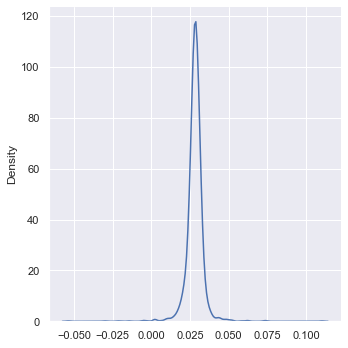

In [692]:
sns.set(rc = {'figure.figsize':(15,8)})
growth = sns.displot(g,kind="kde")
